In [41]:
import h5py
import numpy as np

datasets = h5py.File('/home/sunji/ANN/fashion_mnist_784_euclidean/fashion-mnist-784-euclidean.hdf5', 'r')

In [3]:
mini = 100.0
maxi = 0.0
for p in datasets['train']:
    for pp in p:
        if pp > maxi:
            maxi = pp
        if pp < mini:
            mini = pp

In [4]:
print (maxi, mini)

218.0 0.0


In [2]:
datasets['train'][0]

array([0.0459, 0.0439, 0.0251, 0.0318, 0.0159, 0.0564, 0.0335, 0.0273,
       0.0156, 0.0627, 0.0504, 0.0116, 0.0289, 0.0432, 0.0388, 0.0282,
       0.0405, 0.0417, 0.0309, 0.0338, 0.0165, 0.0291, 0.0245, 0.0208,
       0.0207, 0.0727, 0.0386, 0.0145, 0.0347, 0.0462, 0.0238, 0.0333,
       0.0616, 0.0418, 0.0344, 0.0448, 0.0221, 0.0348, 0.0275, 0.0319,
       0.0445, 0.1036, 0.0365, 0.0168, 0.0539, 0.0554, 0.0224, 0.0432,
       0.1612, 0.0764, 0.0892, 0.1059, 0.0974, 0.057 , 0.064 , 0.072 ,
       0.1108, 0.1132, 0.0399, 0.035 , 0.0914, 0.0654, 0.0676, 0.0481,
       0.2254, 0.0976, 0.1954, 0.1424, 0.1787, 0.0932, 0.0989, 0.0909,
       0.1794, 0.0632, 0.104 , 0.0889, 0.1972, 0.0874, 0.1693, 0.1058,
       0.0982, 0.0606, 0.1163, 0.0678, 0.0728, 0.065 , 0.029 , 0.0384,
       0.0692, 0.0409, 0.0631, 0.0669, 0.1183, 0.0573, 0.0792, 0.1229,
       0.0317, 0.0608, 0.0381, 0.0357, 0.0282, 0.0554, 0.0146, 0.0199,
       0.0332, 0.0343, 0.0357, 0.0265, 0.0308, 0.0283, 0.0285, 0.0467,
      

## k-means

In [3]:
def euclidean_dist_normalized(x1, x2=None, eps=1e-8):
    return np.sqrt(((x1 - x2) ** 2).mean())

In [4]:
euclidean_dist_normalized(datasets['train'][0], datasets['train'][100])

0.08118401

In [34]:
from sklearn.decomposition import PCA
from sklearn import manifold

X = np.array(datasets['train'])
pca = PCA(n_components=2)
new_X = pca.fit_transform(X)

In [35]:
from sklearn.cluster import MiniBatchKMeans
import numpy as np

kmeans = MiniBatchKMeans(n_clusters=7,random_state=0,batch_size=100).fit(new_X)

In [36]:
clusters = kmeans.predict(new_X)

In [8]:
clusters

array([79, 42, 10, ..., 78, 95, 53], dtype=int32)

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

data = X / 255.0

tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(data[np.random.choice(data.shape[0], 1000, replace=False)])

In [48]:
kmeans = MiniBatchKMeans(n_clusters=8,random_state=0,batch_size=100).fit(X_tsne)
clusters = kmeans.predict(X_tsne)

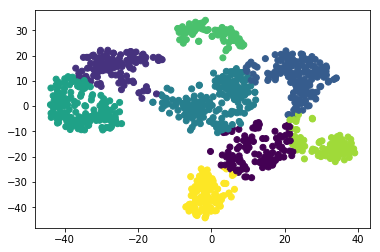

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import cluster, datasets
import random

colors = np.array([x for x in 'bgrcmyk'])
 
# plt.figure(figsize=(16,4))
#画图
# X, y = datasets[2]

# sample_idx = random.sample(range(len(clusters)), 1000)

fig = plt.figure()
plt.subplot()
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=clusters)
fig.show()
# plt.subplot(1,4,i_dataset+1)
# #plt.figure()
# plt.scatter(X[:,0],X[:,1], X[:,2], c=y)
plt.savefig('mnist_sample.eps', format='eps', bbox_inches='tight')

In [ ]:
clusters_points = []
for cluster_id in range(100):
    clusters_points.append(np.array(datasets['train'])[(clusters == cluster_id).nonzero()])

In [ ]:
for cc in clusters_points:
    print (len(cc))

## collect query ground truth

In [11]:
import torch.nn.functional as F

import numpy as np
from numpy import dot
from numpy.linalg import norm
from scipy import spatial

from multiprocessing import Pool

def angular_dist(x1, x2=None, eps=1e-8):
    cosine_sim = 1 - spatial.distance.cosine(x1, x2)
    distance = np.arccos(cosine_sim) / 3.14159267
    return distance

def euclidean_dist_normalized(x1, x2=None, eps=1e-8):
    return np.sqrt(((x1 - x2) ** 2).mean())

queries = np.array(datasets['test'])

def run_proc(clus):
    dataset = clusters_points[clus]
    ground_truth = []
    slot = 0.001
    for idxx, q in enumerate(queries):
        if idxx % 100 == 0:
            print (clus, idxx)
        thresholds = np.arange(0.0, 0.1, slot)
        count = [0 for _ in thresholds]
        for d in dataset:
            distance = euclidean_dist_normalized(q, d)
#             print (distance)
            for idx, threshold in enumerate(thresholds):
                if distance < threshold + slot and distance >= threshold:
                    count[idx] += 1
        for idx, threshold in enumerate(thresholds):
#             print (threshold, threshold + slot, count[idx])
            ground_truth.append((clus, idxx, threshold, threshold + slot, count[idx]))
    return ground_truth
#             print (threshold, threshold + slot, count[idx])
ground_truth_total = []
processes = []
pool = Pool(processes=30)
for clus in range(100):
    processes.append(pool.apply_async(run_proc, args=(clus,)))
pool.close()
pool.join()

for i in processes:
    ground_truth_total.append(i.get())

1 0
0 0
2 0
7 0
4 0
5 0
13 0
12 0
14 0
6 0
15 0
3 0
16 0
17 0
18 0
19 0
22 0
20 0
28 0
23 0
25 0
21 0
26 0
27 0
24 0
29 0
11 0
9 0
8 0
10 0
6 100
28 100
29 100
6 200
17 100
15 100
6 300
3 100
28 200
20 100
12 100
6 400
29 200
10 100
17 200
15 200
24 100
5 100
13 100
28 300
6 500
29 300
6 600
3 200
28 400
17 300
6 700
15 300
20 200
12 200
29 400
6 800
4 100
28 500
10 200
17 400
6 900
27 100
15 400
24 200
5 200
29 500
3 300
28 600
30 0
13 200
20 300
14 100
12 300
17 500
15 500
2 100
28 700
29 600
16 100
18 100
10 300
19 100
17 600
28 800
3 400
29 700
20 400
15 600
24 300
5 300
12 400
13 300
28 900
17 700
9 100
29 800
15 700
4 200
3 500
31 0
20 500
10 400
17 800
29 900
12 500
11 100
27 200
15 800
25 100
24 400
5 400
8 100
17 900
32 0
13 400
3 600
15 900
20 600
26 100
32 100
12 600
14 200
33 0
10 500
22 100
32 200
34 0
21 100
23 100
3 700
34 100
24 500
5 500
2 200
34 200
20 700
0 100
32 300
34 300
12 700
16 200
34 400
13 500
4 300
34 500
10 600
18 200
32 400
19 200
34 600
33 100
3 800
34 7

In [31]:
len(ground_truth_total)

100

In [5]:
ground_truth_total[0]

[(0, 0, 0.0, 0.01, 0),
 (0, 0, 0.01, 0.02, 0),
 (0, 0, 0.02, 0.03, 0),
 (0, 0, 0.03, 0.04, 0),
 (0, 0, 0.04, 0.05, 0),
 (0, 0, 0.05, 0.060000000000000005, 0),
 (0, 0, 0.06, 0.06999999999999999, 0),
 (0, 0, 0.07, 0.08, 0),
 (0, 0, 0.08, 0.09, 0),
 (0, 0, 0.09, 0.09999999999999999, 0),
 (0, 0, 0.1, 0.11, 0),
 (0, 0, 0.11, 0.12, 0),
 (0, 0, 0.12, 0.13, 0),
 (0, 0, 0.13, 0.14, 0),
 (0, 0, 0.14, 0.15000000000000002, 0),
 (0, 0, 0.15, 0.16, 0),
 (0, 0, 0.16, 0.17, 0),
 (0, 0, 0.17, 0.18000000000000002, 0),
 (0, 0, 0.18, 0.19, 2),
 (0, 0, 0.19, 0.2, 5),
 (0, 0, 0.2, 0.21000000000000002, 10),
 (0, 0, 0.21, 0.22, 98),
 (0, 0, 0.22, 0.23, 537),
 (0, 0, 0.23, 0.24000000000000002, 1843),
 (0, 0, 0.24, 0.25, 3412),
 (0, 0, 0.25, 0.26, 2950),
 (0, 0, 0.26, 0.27, 750),
 (0, 0, 0.27, 0.28, 12),
 (0, 0, 0.28, 0.29000000000000004, 0),
 (0, 0, 0.29, 0.3, 0),
 (0, 0, 0.3, 0.31, 0),
 (0, 0, 0.31, 0.32, 0),
 (0, 0, 0.32, 0.33, 0),
 (0, 0, 0.33, 0.34, 0),
 (0, 0, 0.34, 0.35000000000000003, 0),
 (0, 0, 0.3500

In [1]:
import pickle

with open('/home/sunji/ANN/sift_128_euclidean/ground_truth_sift_128_euclidean_0_0_0_5.pkl', 'rb') as f:
    ground_truth_total = pickle.load(f)

In [12]:
import pickle

with open('/home/sunji/ANN/gist_960_euclidean/ground_truth_gist_960_euclidean_0_0_0_1.pkl', 'wb') as f:
    pickle.dump(ground_truth_total, f)

In [13]:
import pickle

with open('/home/sunji/ANN/gist_960_euclidean/clusters_gist_960_euclidean.pkl', 'wb') as f:
    pickle.dump(clusters_points, f)

## Trash Bin

In [190]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.embedding = nn.Linear(dimension, 128)
        self.bn1 = nn.BatchNorm1d(num_features=128)
#         self.embedding2 = nn.Linear(128, 128)
#         self.bn2 = nn.BatchNorm1d(num_features=128)
        self.embedding3 = nn.Linear(128, len_hash_code)

    def forward(self, point):
        # batch * 100 * 25
        # batch * 16
        point1 = F.relu(self.bn1(self.embedding(point)))
#         point2 = F.relu(self.bn2(self.embedding2(point1)))
        point3 = self.embedding3(point1)
        # batch * 100
        return point3

def approximate_hamming_distance(left_embedding, right_embedding):
    return ((left_embedding - right_embedding) ** 2).sum(dim=1)

def euclidean_distance(lefts, rights):
    return ((lefts - rights) ** 2).sum(dim=1)

def l1_distance(lefts, rights):
    return ((lefts - rights) ** 2).sum(dim=1)

def angular_distance(x1, x2=None, eps=1e-8):
    cosine_sim = F.cosine_similarity(x1, x2, dim=1, eps=1e-8)
    distance = torch.acos(cosine_sim) / 3.14159267
    return distance 

def diff_loss(hash_distance, input_distance):
#     print (hash_distance[0])
    input_distance = torch.floor(input_distance * 40)
    return F.mse_loss(input_distance, hash_distance)

def hash_loss(hash_distance, input_distance):
#     return F.mse_loss(hash_distance, input_distance)
#     return (-(hash_distance * input_distance) + 0.02 * (hash_distance.max()) ** 2).mean()
#     print ('new1')
#     print (hash_distance)
#     return - (input_distance * hash_distance + 0.5 * hash_distance).sum() / ((1.0 - input_distance) * hash_distance).sum()
    return ((1.0 - input_distance) ** 2 * hash_distance).sum() - (5 * torch.log(hash_distance + 1.0)).sum()

def triple_loss(embedding_distance, origin_distance):
    loss = 0.0
    loss1 = (embedding_distance[0] - embedding_distance[1]) * ((origin_distance[0] - origin_distance[1]) / torch.abs(origin_distance[0] - origin_distance[1]))
    loss1 = loss1 * (loss1 > 0).type(torch.FloatTensor)
    loss2 = (embedding_distance[1] - embedding_distance[2]) * ((origin_distance[1] - origin_distance[2]) / torch.abs(origin_distance[1] - origin_distance[2]))
    loss2 = loss2 * (loss2 > 0).type(torch.FloatTensor)
    loss3 = (embedding_distance[2] - embedding_distance[0]) * ((origin_distance[2] - origin_distance[0]) / torch.abs(origin_distance[2] - origin_distance[0]))
    loss3 = loss3 * (loss3 > 0).type(torch.FloatTensor)
#     print (embedding_distance[0].size())
#     print (emb.size())
#     print (torch.max(emb, dim=1)[0].size())
    return (loss1 + loss2 + loss3).mean()

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    print(len(train_loader))
#     for round in range(epoch):
        
    for batch_idx, (triple1, triple2, triple3) in enumerate(train_loader):
        triple1, triple2, triple3 = triple1.to(device), triple2.to(device), triple3.to(device)
        optimizer.zero_grad()
        triple1_embedding = model(triple1)
        triple2_embedding = model(triple2)
        triple3_embedding = model(triple3)
#         print ('left_embedding: ', left_embedding.size())
#         print ('right_embedding: ', right_embedding.size())
        embedding_distance_1 = l1_distance(triple1_embedding, triple2_embedding)
        embedding_distance_2 = l1_distance(triple2_embedding, triple3_embedding)
        embedding_distance_3 = l1_distance(triple3_embedding, triple1_embedding)
        origin_distance_1 = angular_distance(triple1, triple2)
        origin_distance_2 = angular_distance(triple2, triple3)
        origin_distance_3 = angular_distance(triple3, triple1)
        
        loss = diff_loss(embedding_distance_1, origin_distance_1)
#         loss = triple_loss((embedding_distance_1, embedding_distance_2, embedding_distance_3),
#                            (origin_distance_1, origin_distance_2, origin_distance_3))
        
#         print ('input_distance: ', input_distance)
#         print ('input_distance: ', input_distance.size())
        loss.backward()
        torch.nn.utils.clip_grad_value_(model.parameters(), 5.0)
        optimizer.step()
#         print ('parameters: ', model.state_dict())
#         print ('gradient', )
        
        if batch_idx % batch_log_interval == 0:
#             for xx in zip(hash_distance, input_distance):
#                 print (xx[0], xx[1])
            print('Train Epoch: {}\tLoss: {}'.format(
                epoch, loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    hash_distances = []
    input_distances = []
    with torch.no_grad():
        for triple1, triple2, triple3 in test_loader:
            triple1, triple2, triple3 = triple1.to(device), triple2.to(device), triple3.to(device)
            triple1_embedding = model(triple1)
            triple2_embedding = model(triple2)
            triple3_embedding = model(triple3)
    #         print ('left_embedding: ', left_embedding.size())
    #         print ('right_embedding: ', right_embedding.size())
            embedding_distance_1 = l1_distance(triple1_embedding, triple2_embedding)
            embedding_distance_2 = l1_distance(triple2_embedding, triple3_embedding)
            embedding_distance_3 = l1_distance(triple3_embedding, triple1_embedding)
            origin_distance_1 = angular_distance(triple1, triple2)
            origin_distance_2 = angular_distance(triple2, triple3)
            origin_distance_3 = angular_distance(triple3, triple1)
            loss = diff_loss(embedding_distance_1, origin_distance_1)
#             loss = triple_loss((embedding_distance_1, embedding_distance_2, embedding_distance_3),
#                                (origin_distance_1, origin_distance_2, origin_distance_3))
    #         print ('input_distance: ', input_distance)
    #         print ('input_distance: ', input_distance.size())
            test_loss += loss.item() # sum up batch loss
    

    test_loss /= len(test_loader)

    print('Test set: Average loss: {:.4f}\n'.format(
        test_loss))
    
    return hash_distances, input_distances

    
def prepare_dataset(training_data, train_num, test_num):
    print (training_data.shape)
    number = train_num % training_data.shape[0]
    train_triple1 = training_data[np.random.choice(training_data.shape[0], number, replace=False)]
    train_triple2 = training_data[np.random.choice(training_data.shape[0], number, replace=False)]
    train_triple3 = training_data[np.random.choice(training_data.shape[0], number, replace=False)]
    number = train_num - train_num % training_data.shape[0]
    while number > training_data.shape[0]:
        train_triple1 = np.concatenate((train_triple1, training_data))
        train_triple2 = np.concatenate((train_triple2, training_data))
        train_triple3 = np.concatenate((train_triple3, training_data))
        np.random.shuffle(train_triple1)
        np.random.shuffle(train_triple2)
        np.random.shuffle(train_triple3)
        number -= training_data.shape[0]
    train_triple1 = np.concatenate((train_triple1, training_data[np.random.choice(training_data.shape[0], number, replace=False)]))
    train_triple2 = np.concatenate((train_triple2, training_data[np.random.choice(training_data.shape[0], number, replace=False)]))
    train_triple3 = np.concatenate((train_triple3, training_data[np.random.choice(training_data.shape[0], number, replace=False)]))
    np.random.shuffle(train_triple1)
    np.random.shuffle(train_triple2)
    np.random.shuffle(train_triple3)
    
    test_triple1 = training_data[np.random.choice(training_data.shape[0], test_num, replace=False)]
    test_triple2 = training_data[np.random.choice(training_data.shape[0], test_num, replace=False)]
    test_triple3 = training_data[np.random.choice(training_data.shape[0], test_num, replace=False)]
    np.random.shuffle(test_triple1)
    np.random.shuffle(test_triple2)
    np.random.shuffle(test_triple3)
    
    return (torch.FloatTensor(train_triple1), torch.FloatTensor(train_triple2), torch.FloatTensor(train_triple3),
            torch.FloatTensor(test_triple1), torch.FloatTensor(test_triple2), torch.FloatTensor(test_triple3))
        

def run():
    # Training settings
#     parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
#     parser.add_argument('--batch-size', type=int, default=64, metavar='N',
#                         help='input batch size for training (default: 64)')
#     parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
#                         help='input batch size for testing (default: 1000)')
#     parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                         help='number of epochs to train (default: 10)')
#     parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
#                         help='learning rate (default: 0.01)')
#     parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
#                         help='SGD momentum (default: 0.5)')
#     parser.add_argument('--no-cuda', action='store_true', default=False,
#                         help='disables CUDA training')
#     parser.add_argument('--seed', type=int, default=1, metavar='S',
#                         help='random seed (default: 1)')
#     parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                         help='how many batches to wait before logging training status')
    
#     parser.add_argument('--save-model', action='store_true', default=False,
#                         help='For Saving the current Model')
#     args = parser.parse_args()
    use_cuda = torch.cuda.is_available()

#     torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    
    train_dataset = np.array(f['train'])
    train_triple1, train_triple2, train_triple3,test_triple1,test_triple2,test_triple3 = prepare_dataset(train_dataset, train_num, test_num)
    
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(train_triple1, train_triple2, train_triple3), batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(test_triple1,test_triple2,test_triple3), batch_size=batch_size, shuffle=True, **kwargs)


    model = Net().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)

    if (save_model):
        torch.save(model.state_dict(),"mnist_cnn.pt")
        
    return model

dimension = 200
len_hash_code = 20
batch_log_interval = 100
batch_size = 1024
train_num = 2000000
test_num = 10000
learning_rate = 0.001
save_model = False
epochs = 20

model = run()

(1183514, 200)
1954
Train Epoch: 1	Loss: 287.8174133300781
Train Epoch: 1	Loss: 41.85979461669922
Train Epoch: 1	Loss: 36.91990280151367
Train Epoch: 1	Loss: 30.303878784179688
Train Epoch: 1	Loss: 28.23041534423828
Train Epoch: 1	Loss: 30.316242218017578
Train Epoch: 1	Loss: 28.25247573852539
Train Epoch: 1	Loss: 29.15850067138672
Train Epoch: 1	Loss: 25.41613006591797
Train Epoch: 1	Loss: 23.38016128540039
Train Epoch: 1	Loss: 23.78240394592285
Train Epoch: 1	Loss: 23.99214744567871
Train Epoch: 1	Loss: 23.212833404541016
Train Epoch: 1	Loss: 21.11407470703125
Train Epoch: 1	Loss: 24.2458553314209
Train Epoch: 1	Loss: 21.179821014404297
Train Epoch: 1	Loss: 22.41728401184082
Train Epoch: 1	Loss: 22.16063690185547
Train Epoch: 1	Loss: 20.664649963378906
Train Epoch: 1	Loss: 21.061704635620117
Test set: Average loss: 21.5539

1954
Train Epoch: 2	Loss: 20.587650299072266
Train Epoch: 2	Loss: 20.98163604736328
Train Epoch: 2	Loss: 21.684144973754883
Train Epoch: 2	Loss: 21.31443405151367

Train Epoch: 12	Loss: 16.87659454345703
Train Epoch: 12	Loss: 16.62636947631836
Train Epoch: 12	Loss: 16.413196563720703
Train Epoch: 12	Loss: 15.419098854064941
Train Epoch: 12	Loss: 17.40289878845215
Train Epoch: 12	Loss: 17.811447143554688
Train Epoch: 12	Loss: 16.522581100463867
Train Epoch: 12	Loss: 17.927831649780273
Train Epoch: 12	Loss: 17.318735122680664
Train Epoch: 12	Loss: 18.549013137817383
Train Epoch: 12	Loss: 16.230228424072266
Train Epoch: 12	Loss: 18.165016174316406
Train Epoch: 12	Loss: 17.228939056396484
Train Epoch: 12	Loss: 16.012344360351562
Train Epoch: 12	Loss: 17.035831451416016
Train Epoch: 12	Loss: 16.66451644897461
Train Epoch: 12	Loss: 16.52361297607422
Train Epoch: 12	Loss: 18.191444396972656
Train Epoch: 12	Loss: 16.39803123474121
Train Epoch: 12	Loss: 17.10996437072754
Test set: Average loss: 17.6079

1954
Train Epoch: 13	Loss: 16.86856460571289
Train Epoch: 13	Loss: 16.970827102661133
Train Epoch: 13	Loss: 17.090402603149414
Train Epoch: 13	Loss: 17.39

In [181]:
# print(model(torch.FloatTensor(f['train'][0])))
# print(model(torch.FloatTensor(f['train'][1])))
print(model.state_dict())

OrderedDict([('embedding.weight', tensor([[-0.0737,  0.0348,  0.1314,  ...,  0.1007, -0.1645, -0.0022],
        [-0.1440, -0.0753,  0.0086,  ...,  0.1420, -0.1070, -0.1864],
        [-0.1549,  0.0102, -0.0597,  ...,  0.3419, -0.2087,  0.2633],
        ...,
        [-0.1806,  0.0052, -0.1953,  ..., -0.2890,  0.2879,  0.0219],
        [-0.2083, -0.0856,  0.0666,  ...,  0.0547,  0.3166, -0.0631],
        [-0.0979, -0.2676,  0.1037,  ...,  0.3026,  0.2987,  0.0413]])), ('embedding.bias', tensor([ 8.6811e-03, -1.7215e-01,  2.3615e-02,  9.8484e-02,  4.0655e-02,
        -1.8462e-01,  6.9176e-02,  6.2844e-02,  1.4881e-01, -1.7385e-02,
         7.8375e-02, -7.1028e-02,  1.1992e-01,  9.8158e-02,  1.0858e-01,
         1.9353e-01,  8.4987e-02,  5.3705e-02,  8.8571e-02,  3.5341e-02,
         1.8660e-01, -1.5163e-02, -7.5211e-03,  1.9328e-01, -7.5381e-02,
        -5.3284e-02,  1.8961e-02,  5.9003e-02,  2.9577e-02,  6.9137e-02,
        -9.5267e-03, -1.3065e-01, -5.7908e-02,  1.1988e-02,  6.4179e-02,


In [ ]:
use_cuda = torch.cuda.is_available()

#     torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
train_dataset = np.array(f['train'])
test_dataset = np.array(f['test'])
train_lefts, train_rights, test_lefts, test_rights = prepare_dataset(train_dataset, test_dataset, train_num, test_num)

train_loader = torch.utils.data.DataLoader(
    (train_lefts, train_rights), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    (test_lefts, test_rights), batch_size=batch_size, shuffle=True)


In [ ]:
# hash_distances, input_distances = test(model, device, train_loader)
hash_distances, input_distances = test(model, device, test_loader)

In [191]:
lefts = torch.FloatTensor([f['train'][0] for x in range(999)])
rights = torch.FloatTensor(f['train'][1:1000])
inputdistance = angular_distance(lefts, rights).detach().numpy()
hashdistance = l1_distance(model(lefts), model(rights)).detach().numpy()


In [192]:
# for xx in zip(inputdistance, hashdistance):
#     print (xx[0], xx[1])
index_1 = np.argsort(hashdistance, 0)
index_2 = np.argsort(inputdistance, 0)
# np.random.shuffle(index_2)

input_index = {}
for pos, idx in enumerate(index_2):
    input_index[idx] = pos
sum = 0.0
for pos, idx in enumerate(index_1):
    sum += np.abs(pos - input_index[idx])
sum / len(index_1)

206.8208208208208

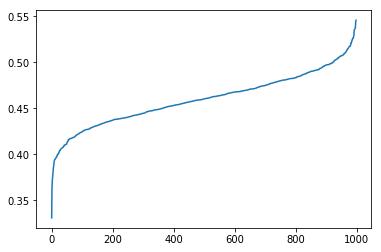

In [104]:
xxx = np.sort(inputdistance, 0)
plt.plot(xxx)
plt.show()

In [193]:
import math
distances = []
for i in index_1:
    distances.append(math.floor(inputdistance[i].item()* 40))

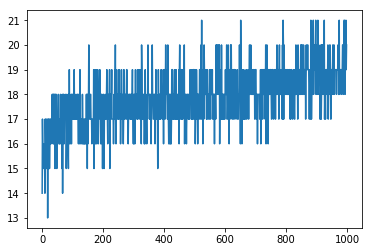

In [194]:
import matplotlib.pyplot as plt

plt.plot(distances)
plt.show()

In [46]:
F.cosine_similarity(torch.FloatTensor(f['train'][0]).unsqueeze(0), torch.FloatTensor(f['train'][6]).unsqueeze(0), dim=1, eps=1e-8)

tensor([0.3993])

In [ ]:
for x, y in zip(hash_distances[0][0:30], input_distances[0][0:30]):
    print (x, y)

In [ ]:
dataset_vector = model(torch.FloatTensor(f['train']))

In [ ]:
query_vector = model(torch.FloatTensor(f['test']))

In [ ]:
def binarization(vector):
    query_codes = []
    for v in vector:
        binary_code = []
        for e in v:
            if e < 0.5:
                binary_code.append(0)
            else:
                binary_code.append(1)
        query_codes.append(binary_code)
    return np.array(query_codes)
dataset_binary = binarization(dataset_vector.detach().numpy())
query_binary = binarization(query_vector.detach().numpy())

In [ ]:
len(dataset_binary)

In [ ]:
len(query_binary)

In [ ]:
import math
hash_table = {}
for idx, point in enumerate(dataset_binary):
    pos = 0
    key = 0
    for d in point:
        key += d * math.pow(2, pos)
        pos += 1
    if key in hash_table:
        hash_table[key].append(idx)
    else:
        hash_table[key] = [idx]

In [ ]:
f['neighbors'][:]

In [ ]:
def find_candidate_distance(vector, hash_table, candidate_num):
    candidate = []
    for point in query_binary:
        cand = []
        dis = 0
        while len(cand) < 100:
            pos = 0
            key = 0
            for d in point:
                key += d * math.pow(2, pos)
                pos += 1
            if key in hash_table:
                candidate.append(hash_table[key])
    return candidate
find_candidate_0_distance(query_binary, hash_table)

In [ ]:
class Node(object):
    def __init__(hash_code, data_index_set):
        self.hash_code = hash_code
        self.data_index_set = data_index_set
        self.children = []
        
    def isLeaf():
        return len(self.children) == 0
    
    def train(dataset):
        train_data = dataset[self.data_index_set]
        self.model = train(dataset)
        
    def partition():
        points = dataset[self.data_index_set]
        hash_table = {}
        codes = self.model(points)
        for idx, code in enumerate(codes):
            if code in hash_table:
                hash_table[code].append(self.data_index_set[idx])
            else:
                hash_table[code] = [self.data_index_set[idx]]
        for key,value in d.items():
            self.children.append(Node(key, value))
    
    def search(query, dataset):
        if self.isLeaf():
            return validate(dataset[self.data_index_set])
        else:
            children_idxes = select_children(query)
            result = []
            for idx in children_idxes:
                result += self.children[idx].search(query, dataset)
            return result
    
    
    

def index_construction(dataset):
    model = train(dataset)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold, datasets

data = np.array(f['train'])

tsne = manifold.TSNE(n_components=2, init='pca', random_state=501)
X_tsne = tsne.fit_transform(data[np.random.choice(data.shape[0], 100000, replace=False)])